In [1]:
# Required inputs

import numpy as np
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

In [2]:
# Define function to load all npy files in a given directory while preserving the order and return

def load_npy_arrays(directory):

    file_list = [file for file in os.listdir(directory) if file.endswith('.npy')]
    file_list = sorted(file_list, key=lambda x: int(os.path.splitext(x)[0]))

    loaded_arrays = []

    for file in tqdm(file_list):
        file_path = os.path.join(directory, file)
        data = np.load(file_path)
        loaded_arrays.append(data)

    return np.vstack(loaded_arrays)

In [3]:
# Load saved emotion scores and W+ latents

emotion_scores = load_npy_arrays('main_emotionscores')
wp_latents = load_npy_arrays('main_wplusses')

100%|██████████| 10000/10000 [01:02<00:00, 160.60it/s]


In [4]:
# Delete invalid rows, where there is no face

invalid_idcs = []
for i, score in enumerate(emotion_scores.tolist()):
    if score[0] == -1:
        invalid_idcs.append(i)
emotion_scores = np.delete(emotion_scores, invalid_idcs, axis=0)
wp_latents = np.delete(wp_latents, invalid_idcs, axis=0)

In [5]:
emotion_scores.shape

(319472, 8)

In [6]:
emotion_mapping_8 = {0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}

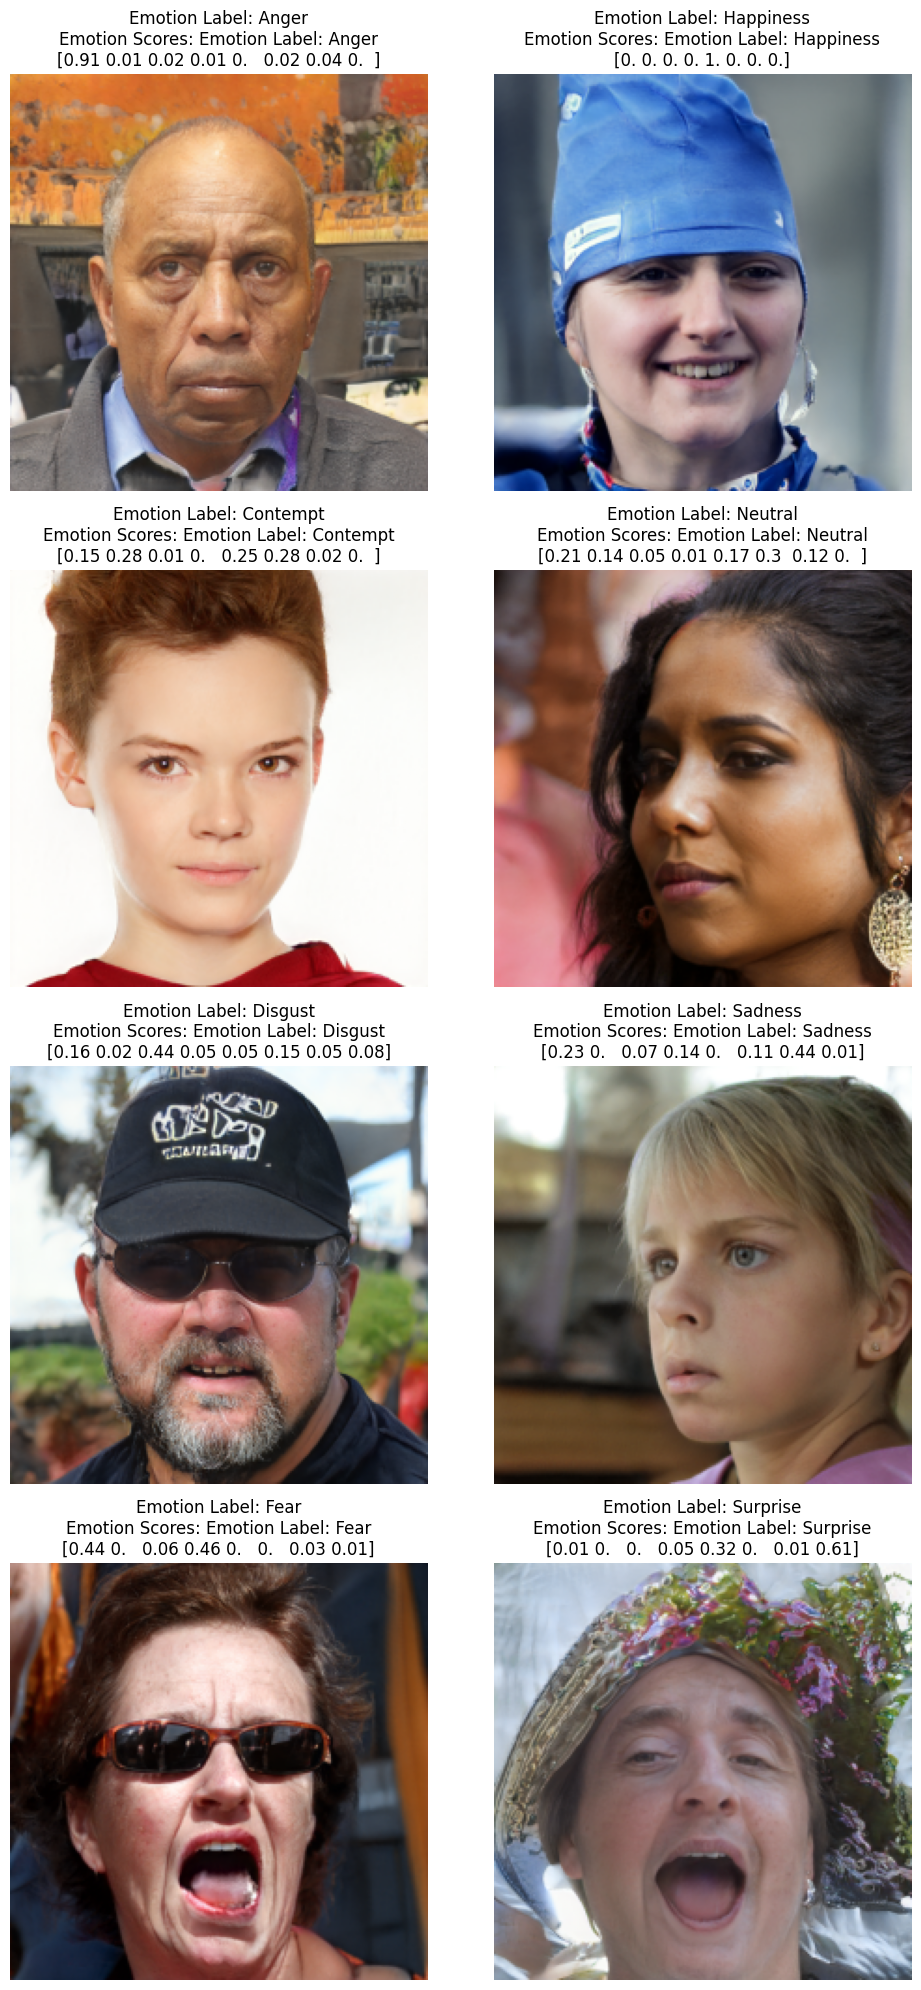

In [ ]:
# Load a random image from the generated set and display its emotion label and scores

emotion_mapping_8 = {0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}
image_path = 'main_generatedimages'

def given_class_return_sample(class_name):
    while True:
        random_index = random.randint(0, len(emotion_scores) - 1)
        random_image = plt.imread(os.path.join(image_path, f"{random_index}.png"))

        emotion_label = emotion_mapping_8[np.argmax(emotion_scores[random_index])]
        if emotion_label == class_name:
            descriptor = f"Emotion Label: {emotion_label}\n{np.array_str(emotion_scores[random_index], precision=2, suppress_small=True)}"
            return random_image, descriptor

fig, axes = plt.subplots(len(emotion_mapping_8) // 2, 2, figsize=(10, 20))

for i, (class_name, class_label) in enumerate(emotion_mapping_8.items()):
    sample = given_class_return_sample(class_label)
    if i < len(emotion_mapping_8)//2:
        axes[i, 0].imshow(sample[0])
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Emotion Label: {class_label}\nEmotion Scores: {sample[1]}')
    else:
        i = i - len(emotion_mapping_8)//2
        axes[i, 1].imshow(sample[0])
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'Emotion Label: {class_label}\nEmotion Scores: {sample[1]}')
plt.tight_layout()
plt.show()

In [7]:
# Scale W+'s before feeding them to SVM Regressor

from sklearn.preprocessing import MinMaxScaler

wp_latents_reshaped = wp_latents.reshape(-1, 18*512) # Flatten the latent codes before passing to SVM so that (total, 18*512)
wp_latents_reshaped = MinMaxScaler(feature_range=(-1,1)).fit_transform(wp_latents_reshaped)

import gc
del(wp_latents)
gc.collect();

In [8]:
# My memory can not handle processing all data via LinearSVR at once, I will use batches of 50k

from sklearn.svm import LinearSVR

def extract_directions_for_given_emotion(emo_idx, batch_size=50000):
    svr_coeffs = []
    batch_amount = emotion_scores.shape[0] // batch_size
    for i in tqdm(range(batch_amount)):
        svm = LinearSVR(dual='auto')
        svm.fit(wp_latents_reshaped[i*batch_size:(i+1)*batch_size], emotion_scores[i*batch_size:(i+1)*batch_size, emo_idx])
        svr_coeffs.append(svm.coef_.reshape(18, 512).copy())
    svr_coeffs_mean = np.mean(svr_coeffs, axis=0)
    return svr_coeffs_mean

def extract_directions_for_given_emotion_and_save(emo_idx, dir_path):
    direction = extract_directions_for_given_emotion(emo_idx)
    np.save(os.path.join(dir_path, f'{emo_idx}.npy'), direction)

In [10]:
# Find and save the directions for the first (Anger) emotion

print(f"Currently processing for the emotion {emotion_mapping_8[0]}")
extract_directions_for_given_emotion_and_save(0, 'main_directions')

Currently processing for the emotion Anger


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 17%|█▋        | 1/6 [13:02<1:05:11, 782.23s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 33%|███▎      | 2/6 [26:06<52:12, 783.19s/it]  c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 50%|█████     | 3/6 [39:25<39:31, 790.44s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 67%|

In [9]:
# Find and save the directions for the second (Contempt) emotion

print(f"Currently processing for the emotion {emotion_mapping_8[1]}")
extract_directions_for_given_emotion_and_save(1, 'main_directions')

Currently processing for the emotion Contempt


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 17%|█▋        | 1/6 [13:22<1:06:53, 802.66s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 33%|███▎      | 2/6 [27:30<55:17, 829.34s/it]  c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 50%|█████     | 3/6 [41:45<42:02, 840.79s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 67%|

In [10]:
# Find and save the directions for the third (Disgust) emotion

print(f"Currently processing for the emotion {emotion_mapping_8[2]}")
extract_directions_for_given_emotion_and_save(2, 'main_directions')

Currently processing for the emotion Disgust


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 17%|█▋        | 1/6 [13:10<1:05:52, 790.56s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 33%|███▎      | 2/6 [26:20<52:40, 790.05s/it]  c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 50%|█████     | 3/6 [39:28<39:27, 789.32s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 67%|

In [11]:
# Find and save the directions for the forth (Fear) emotion

print(f"Currently processing for the emotion {emotion_mapping_8[3]}")
extract_directions_for_given_emotion_and_save(3, 'main_directions')

Currently processing for the emotion Fear


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 17%|█▋        | 1/6 [13:11<1:05:57, 791.43s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 33%|███▎      | 2/6 [26:21<52:42, 790.54s/it]  c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 50%|█████     | 3/6 [39:33<39:34, 791.35s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 67%|

In [12]:
# Find and save the directions for the fifth (Happiness) emotion

print(f"Currently processing for the emotion {emotion_mapping_8[4]}")
extract_directions_for_given_emotion_and_save(4, 'main_directions')

Currently processing for the emotion Happiness


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 17%|█▋        | 1/6 [13:09<1:05:49, 789.98s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 33%|███▎      | 2/6 [26:19<52:38, 789.60s/it]  c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 50%|█████     | 3/6 [39:27<39:27, 789.10s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 67%|

In [9]:
# Find and save the directions for the sixth (Neutral) emotion

print(f"Currently processing for the emotion {emotion_mapping_8[5]}")
extract_directions_for_given_emotion_and_save(5, 'main_directions')

Currently processing for the emotion Neutral


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 17%|█▋        | 1/6 [12:50<1:04:10, 770.12s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 33%|███▎      | 2/6 [25:27<50:49, 762.35s/it]  c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 50%|█████     | 3/6 [37:59<37:53, 757.88s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 67%|

In [10]:
# Find and save the directions for the seventh (Sadness) emotion

print(f"Currently processing for the emotion {emotion_mapping_8[6]}")
extract_directions_for_given_emotion_and_save(6, 'main_directions')

Currently processing for the emotion Sadness


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 17%|█▋        | 1/6 [12:30<1:02:31, 750.35s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 33%|███▎      | 2/6 [25:01<50:02, 750.57s/it]  c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 50%|█████     | 3/6 [37:32<37:33, 751.08s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 67%|

In [11]:
# Find and save the directions for the eighth (Surprise) emotion

print(f"Currently processing for the emotion {emotion_mapping_8[7]}")
extract_directions_for_given_emotion_and_save(7, 'main_directions')

Currently processing for the emotion Surprise


  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 17%|█▋        | 1/6 [12:30<1:02:30, 750.01s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 33%|███▎      | 2/6 [24:59<49:59, 749.79s/it]  c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 50%|█████     | 3/6 [37:27<37:27, 749.06s/it]c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 67%|